In [1]:
# 02/19/24 - This notebook redoes some of the kinematic analysis I did for paper 1. See 021924_slacs_kinematics_analysis.ipynb

In [2]:
################################################################

# import general libraries and modules
import numpy as np
np.set_printoptions(threshold=10000)
import matplotlib.pyplot as plt
import matplotlib.colors as colors
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams.update({'font.size': 14})
import pandas as pd
import warnings
warnings.filterwarnings( "ignore", module = "matplotlib\..*" )
warnings.filterwarnings( "ignore", module = "plotbin\..*" )
from os import path
import glob
#import Image from PIL
from PIL import Image
import pickle
from scipy import stats
#import uncertainties.unumpy as unp
#import uncertainties as unc

# astronomy/scipy
from astropy.io import fits
from astropy.wcs import WCS
from scipy.ndimage import rotate
from scipy.ndimage import map_coordinates
from scipy.optimize import least_squares as lsq
from astropy.convolution import convolve, convolve_fft, Gaussian2DKernel
#from astropy.cosmology import Planck15 as cosmo  # Originally I did Planck 2018, but it seems this one isn't in the version of astropy we have on here and I'm not 
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
from scipy.interpolate import interp1d
from scipy.optimize import fsolve

# mge fit
import mgefit
from mgefit.find_galaxy import find_galaxy
from mgefit.mge_fit_1d import mge_fit_1d
from mgefit.sectors_photometry import sectors_photometry
from mgefit.mge_fit_sectors import mge_fit_sectors
from mgefit.mge_print_contours import mge_print_contours
from mgefit.mge_fit_sectors_regularized import mge_fit_sectors_regularized


# jam
from jampy.jam_axi_proj import jam_axi_proj
from jampy.jam_axi_proj import rotate_points
from jampy.jam_axi_proj import bilinear_interpolate
from jampy.mge_half_light_isophote import mge_half_light_isophote
from plotbin.plot_velfield import plot_velfield
from plotbin.sauron_colormap import register_sauron_colormap
#register_sauron_colormap()
from pafit.fit_kinematic_pa import fit_kinematic_pa

# my functions
import sys
sys.path.append("/home/shawnknabel/Documents/slacs_kinematics/my_python_packages")
from slacs_mge_jampy import crop_center_image
from slacs_mge_jampy import import_center_crop
from slacs_mge_jampy import try_fractions_for_find_galaxy
from slacs_mge_jampy import convert_mge_model_outputs
from slacs_mge_jampy import plot_contours_321
from slacs_mge_jampy import load_2d_kinematics
from slacs_mge_jampy import bin_velocity_maps
from slacs_mge_jampy import rotate_bins
from slacs_mge_jampy import osipkov_merritt_model
from slacs_mge_jampy import find_half_light
from slacs_mge_jampy import calculate_minlevel
from slacs_mge_jampy import fit_kcwi_sigma_psf
from slacs_mge_jampy import optimize_sigma_psf_fit
from slacs_mge_jampy import estimate_hst_psf

################################################################
# some needed information
kcwi_scale = 0.1457  # arcsec/pixel
hst_scale = 0.050 # ACS/WFC
# B band (F435W) dust extinction ~ 0.116 from https://irsa.ipac.caltech.edu/applications/DUST/
extinction = 0.116
### photometric zeropoint for F435W as of 2007 was 25.745
photometric_zeropoint = 25.745
# redshift, convert to angular diameter dist in Mpc
z = 0.195
distance = cosmo.angular_diameter_distance(z).value

# specify object directory and name

#################################################
# date and number of initial kinematics run e.g. 2023-02-28_2
date_of_kin = '2024_02_15'
date_of_mge = '2023-02-28_2' # The MGEs I did for these kinematics will still be good. don't need to redo them

###################################################################################################################################

#------------------------------------------------------------------------------
# Directories and files

# data directory
data_dir = '/data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/'
hst_dir = '/data/raw_data/HST_SLACS_ACS/kcwi_kinematics_lenses/'
table_dir = f'{data_dir}tables/'
mosaics_dir = f'{data_dir}mosaics/'
kinematics_full_dir = f'{data_dir}kinematics/'
kinematics_dir =f'{kinematics_full_dir}{date_of_kin}/'
print(f'Outputs will be in {kinematics_dir}')
print()

# target SN for voronoi binning
vorbin_SN_targets = np.array([15])#10, 15, 20])

#################################################
# objects
obj_names = ['SDSSJ0029-0055',
             'SDSSJ0037-0942',
             'SDSSJ0330-0020',
             'SDSSJ1112+0826',
             'SDSSJ1204+0358',
             'SDSSJ1250+0523',
             'SDSSJ1306+0600',
             'SDSSJ1402+6321',
             'SDSSJ1531-0105',
             'SDSSJ1538+5817',
             'SDSSJ1621+3931',
             'SDSSJ1627-0053',
             'SDSSJ1630+4520',
             'SDSSJ2303+1422'
            ]

#################################################

Outputs will be in /data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/kinematics/2024_02_15/



# Paper Table

In [3]:
paper_table = pd.read_csv(f'{table_dir}paper_table_102023.csv')

ellipticities = paper_table.ellipticity
classes = paper_table.class_for_JAM_models

# Bring in the atlas 3d data

In [4]:
## asb is the label, unsure of meaning
atlas3d = np.genfromtxt(f'{data_dir}atlas3d/Emsellem2011_Atlas3D_Paper3_TableB1.txt', skip_header=True)#, names=True)
a3d_eps_vs_lr = atlas3d[:,[2,5,7]]

# Make markers for plotting

In [5]:
# make elliptical marker
import matplotlib.path as mpath

# Define the ellipse marker.
circle = mpath.Path.unit_circle()
elliptical_verts = np.copy(circle.vertices)
elliptical_verts[:, 0] *= 1.618
elliptical_marker = mpath.Path(elliptical_verts, circle.codes)

# define negative smaller ellipse
inner_ell_verts = elliptical_verts * 0.8

# make ellipse with line marker
rect = mpath.Path.unit_rectangle()
rect_verts = np.copy(rect.vertices)
rect_verts[:,0] *= 0.1
rect_verts[:,1] *= 2.0
line_marker = mpath.Path(rect_verts, rect.codes)

# make another line marker lower
second_line_verts = rect_verts.copy()
second_line_verts[:,1] += -3.5
second_line_verts[:,1] *= 0.5

rotator = mpath.Path(
    vertices=np.concatenate([elliptical_verts, inner_ell_verts[::-1, ...], rect_verts, second_line_verts]),
    codes=np.concatenate([circle.codes, circle.codes, rect.codes, rect.codes]))

nonregular = 'o'

# make a question mark
uncertain_mark = '$?$'

# fast/non (kdc)
kdc_mark = '^'


# The V/sigma and Lambda_R plots require some lines that are calculated theoretically

In [6]:

def calc_V_sigma_squared (delta, omega, alpha, i):
    
    if delta >= 1 - 1/omega: # upper limit by tensor virial theorem
        V_sigma_sq = 'NaN'
        return V_sigma_sq
    
    else:
        # radians
        i = i * np.pi/180

        numerator = (1-delta) * omega - 1
        denominator = alpha * (1-delta) * omega + 1

        V_sigma_sq = numerator/denominator

        # project by i
        V_sigma_sq = V_sigma_sq * (np.sin(i))**2 / (1 - delta * (np.cos(i))**2)

        return V_sigma_sq

def calc_omega (e):
    
    numerator = np.arcsin(e)/np.sqrt(1-e**2) - e
    denominator = e - np.arcsin(e) * np.sqrt(1-e**2)
    
    omega = 0.5 * numerator/denominator
    
    return omega

def calc_e (epsilon_intr):
    
    e = np.sqrt( 1 - (1 - epsilon_intr)**2 )
    
    return e

def calc_eps_intr (epsilon, i):
    
    # radians
    i = i * np.pi/180
    
    epsilon_intr = 1 - np.sqrt(1 + epsilon * (epsilon - 2)/(np.sin(i))**2)
    
    return epsilon_intr

def calc_i_from_eps_intr (epsilon, epsilon_intr):
    
    i = np.arcsin( np.sqrt( epsilon/epsilon_intr * (epsilon - 2) / (epsilon_intr - 2)) )
    
    # put in degrees
    i = i * 180 / np.pi
    
    return(i)

def calc_isotropic_V_sigma (epsilon, i):
    
    # isotropic delta = 0
    delta = 0
    # alpha empirically = 0.15
    alpha = 0.15
    
    # calculations
    epsilon_intr = calc_eps_intr(epsilon, i)
    e = calc_e(epsilon_intr)
    omega = calc_omega(e)
    V_sigma_squared = calc_V_sigma_squared(delta, omega, alpha, i)
    V_sigma_iso = np.sqrt(V_sigma_squared)
    
    return(V_sigma_iso)

def calc_V_sigma_magenta_line (epsilon, i, epsilon_intr=None):
    
    # alpha empirically = 0.15
    alpha = 0.15
    
    # calculations
    if epsilon_intr is None:
        epsilon_intr = calc_eps_intr(epsilon, i)
    else:
        i = calc_i_from_eps_intr(epsilon, epsilon_intr)
    e = calc_e(epsilon_intr)
    omega = calc_omega(e)
    # isotropic delta = 0
    delta = 0.7 * epsilon_intr
    
    V_sigma_squared = calc_V_sigma_squared(delta, omega, alpha, i)
    V_sigma_magenta = np.sqrt(V_sigma_squared)
    
    return(V_sigma_magenta)


def calc_lambda_R (V_array, VD_array, R_array, lum_array):
    
    assert (len(V_array)==len(VD_array)) & (len(V_array)==len(lum_array)) & (len(V_array)==len(R_array))
    
    numerator = 0
    denominator = 0
    
    for i in range(len(V_array)):
        V = V_array[i]
        VD = VD_array[i]
        lum = lum_array[i]
        R = R_array[i]
        
        num = lum * R * np.abs(V)
        den = lum * R * np.sqrt(V**2 + VD**2)
        
        numerator += num
        denominator += den
        
    lambda_R = numerator / denominator
    
    return lambda_R

def calc_Vsig_to_lamR (V_sigma):
    k = 1.1
    numerator = k * V_sigma
    denominator = np.sqrt(1 + k**2 * V_sigma**2)
    lamR = numerator/denominator
    return lamR

def calc_R (bin_arrays, num_bins):
    
    bin_R_means = np.zeros(num_bins)
    
    for i in range(num_bins):
        bin_pixels = bin_arrays[bin_arrays[:,2]==i]
        bin_xx = bin_pixels[:,0] - 21 # subtract 21 pixels, center don't know which is x and which is y, but doesn't matter for R
        bin_yy = bin_pixels[:,1] - 21
        bin_R = np.zeros(len(bin_pixels))
        for j in range(len(bin_pixels)):
            bin_R[j] = np.sqrt(bin_xx[j]**2 + bin_yy[j]**2)
        bin_R_means[i] = np.mean(bin_R)*0.1457
        
    return bin_R_means

In [7]:
# inclinations
incs = np.array([15, 30, 45, 60, 75, 90])
eps_intrs = np.arange(0.1,0.9,0.1)

plt.rcParams.update({'font.size': 14})

epsilons = np.linspace(0.0,1.0,1000)
V_sigmas_iso = np.zeros(1000)
lambda_Rs_iso = np.zeros(1000)
V_sigmas_magenta = np.zeros((len(incs), 1000)) # Do the magenta over 6 inclinations
lambda_Rs_magenta = np.zeros((len(incs), 1000)) # Do the magenta over 6 inclinations
V_sigmas_mag_intrs = np.zeros((len(eps_intrs), 1000))
lambda_Rs_mag_intrs = np.zeros((len(eps_intrs), 1000))

i=0
for epsilon in epsilons:
    V_sigma = calc_isotropic_V_sigma(epsilon, 90)
    V_sigmas_iso[i] = V_sigma
    lambda_Rs_iso[i] = calc_Vsig_to_lamR(V_sigma)
    i = i+1
    
for i, epsilon in enumerate(epsilons):
    for j, inc in enumerate(incs):
        V_sigma = calc_V_sigma_magenta_line(epsilon, inc)
        V_sigmas_magenta[j,i] = V_sigma
        lambda_Rs_magenta[j,i] = calc_Vsig_to_lamR(V_sigma)
    for k, eps_intr in enumerate(eps_intrs):
        V_sigma = calc_V_sigma_magenta_line(epsilon, 90, epsilon_intr=eps_intr)
        V_sigmas_mag_intrs[k,i] = V_sigma
        lambda_Rs_mag_intrs[k,i] = calc_Vsig_to_lamR(V_sigma)

/tmp/ipykernel_114913/2476325670.py:26: RuntimeWarning: invalid value encountered in scalar divide
  omega = 0.5 * numerator/denominator
/tmp/ipykernel_114913/2476325670.py:23: RuntimeWarning: divide by zero encountered in scalar divide
  numerator = np.arcsin(e)/np.sqrt(1-e**2) - e
/tmp/ipykernel_114913/2476325670.py:14: RuntimeWarning: invalid value encountered in scalar divide
  V_sigma_sq = numerator/denominator
/tmp/ipykernel_114913/2476325670.py:41: RuntimeWarning: invalid value encountered in sqrt
  epsilon_intr = 1 - np.sqrt(1 + epsilon * (epsilon - 2)/(np.sin(i))**2)
/tmp/ipykernel_114913/2476325670.py:47: RuntimeWarning: invalid value encountered in arcsin
  i = np.arcsin( np.sqrt( epsilon/epsilon_intr * (epsilon - 2) / (epsilon_intr - 2)) )


In [8]:
for i in range(len(V_sigmas_magenta)):
    V_sigmas_magenta[i][V_sigmas_magenta[i]>V_sigmas_mag_intrs[-1]] = 'Nan'

# Functions to calculate the luminosity-weighted aperture velocities

In [9]:
# Define function to calculate luminosity weights for rebinning from Voronoi bins to shells
### In this case, the shell will justbe the effective radius (shells = [1])

def calc_luminosity_weights_in_shells (bin_arrays, num_bins, bin_luminosities, pixel_luminosities, shells, reff):
    
    # create array with each bin and len num_bins
    luminosity_weights = np.zeros((num_bins, len(shells)))
    
    for i in range(num_bins):
        # pixels in this bin, take x and y coordinates
        in_bin = bin_arrays[:,2]==i
        bin_pixels = bin_arrays[in_bin]
        bin_xx = bin_pixels[:,0] - 21 # subtract 21 pixels, center don't know which is x and which is y, but doesn't matter for R
        bin_yy = bin_pixels[:,1] - 21
        # luminosity of bin and of pixels in bin
        #bin_luminosity = bin_luminosities[i]
        bin_pixels_lum = pixel_luminosities[in_bin]
        #print(bin_luminosity, np.sum(bin_pixels_lum))
        # calculate radius of each pixel in the bin
        bin_R = np.zeros(len(bin_pixels))
        for j in range(len(bin_pixels)):
            bin_R[j] = np.sqrt(bin_xx[j]**2 + bin_yy[j]**2)*0.1457 # arcsec
        # calculate fraction of these pixels in each shell
        for k in range(len(shells)):
            inner_shell = shells[k]
            if k == len(shells) - 1:
                outer_shell = 10 # everything extending to the farthest pixel
            else:
                outer_shell = shells[k+1]
            in_shell = (bin_R >= inner_shell*reff) & (bin_R <= outer_shell*reff)
            # weight pixels by fractional luminosity of total bin
            bin_luminosity_in_shell = np.sum(bin_pixels_lum[in_shell])#/bin_luminosity
            luminosity_weights[i,k] = bin_luminosity_in_shell
        
    return luminosity_weights

def lum_weight_bin (V, VD, dV, dVD, lum):
    
    bin_weighted_V_sq = lum * V**2
    bin_weighted_VD_sq = lum * VD**2
    bin_weighted_dV_sq = lum * 2 * V * dV
    bin_weighted_dVD_sq = lum * 2 * VD * dVD

    return bin_weighted_V_sq, bin_weighted_VD_sq, bin_weighted_dV_sq, bin_weighted_dVD_sq

def lum_weight_V_sigma (V_array, VD_array, dV_array, dVD_array, lum_array):
    
    assert (len(V_array)==len(VD_array)) & (len(V_array)==len(lum_array)) & (len(V_array)==len(dVD_array))
    
    V_sq = 0
    VD_sq = 0
    dV_sq = 0
    dVD_sq = 0
    
    for i in range(len(V_array)):
        bin_V_sq, bin_VD_sq, bin_dV_sq, bin_dVD_sq = lum_weight_bin(V_array[i], VD_array[i], dV_array[i], dVD_array[i], lum_array[i])
        V_sq += bin_V_sq
        VD_sq += bin_VD_sq
        dV_sq += bin_dV_sq
        dVD_sq += bin_dVD_sq
    
    V_sigma_sq = V_sq/VD_sq
    V_sigma = np.sqrt(V_sigma_sq)
    
    V_integrated_rms = np.sqrt(V_sq/np.sum(lum_array))
    VD_integrated_rms = np.sqrt(VD_sq/np.sum(lum_array))
    
    dV_int_rms = dV_sq / (2 * np.sqrt(np.sum(lum_array) * V_sq))
    dVD_int_rms = dVD_sq / (2 * np.sqrt(np.sum(lum_array) * VD_sq))
    
    return(V_sigma, V_integrated_rms, VD_integrated_rms, dV_int_rms, dVD_int_rms) # this is integrated out to the edge of my data right now
        
    
# Define function to assign velocities to each pixel from their Voronoi bin, taking only those within the effective radius

def calc_aperture_velocities_from_lum_weight_pixels (bin_arrays, V_array, VD_array, dV_array, dVD_array, pixel_luminosities, reff):
    
    # create array for velocity of each pixel
    pixel_Vs = np.zeros(len(pixel_luminosities))
    pixel_VDs = np.zeros(len(pixel_luminosities))
    pixel_dVs = np.zeros(len(pixel_luminosities))
    pixel_dVDs = np.zeros(len(pixel_luminosities))
    velocity_in_aperture = 0
    
    for i in range(num_bins):
        # pixels in this bin
        in_bin = bin_arrays[:,2]==i
        bin_pixels = bin_arrays[in_bin]
        # add velocity to the weighted_pixel_velocities
        pixel_Vs[in_bin] = V_array[i]
        pixel_VDs[in_bin] = VD_array[i]
        pixel_dVs[in_bin] = dV_array[i]  
        pixel_dVDs[in_bin] = dVD_array[i]       
        
    # get radius of pixels
    pixel_xx = bin_arrays[:,0] - 21 # subtract 21 pixels, center don't know which is x and which is y, but doesn't matter for R
    pixel_yy = bin_arrays[:,1] - 21
    # calculate radius of each pixel
    pixel_radii = np.sqrt(pixel_xx**2 + pixel_yy**2)*0.1457 # arcsec
    # if they are in the effective radius
    in_aperture = (pixel_radii <= reff)
    
    # take values only in the aperture for weighting
    pixel_Vs_aperture = pixel_Vs[in_aperture]
    pixel_VDs_aperture = pixel_VDs[in_aperture]
    pixel_dVs_aperture = pixel_dVs[in_aperture]
    pixel_dVDs_aperture = pixel_dVDs[in_aperture]
    pixel_radii_aperture = pixel_radii[in_aperture]
    pixel_luminosities_aperture = pixel_luminosities[in_aperture]
    
    # mask all NaN values
    V_mask = np.isfinite(pixel_Vs_aperture)
    VD_mask = np.isfinite(pixel_VDs_aperture)
    dV_mask = np.isfinite(pixel_dVs_aperture)
    dVD_mask = np.isfinite(pixel_dVDs_aperture)
    rad_mask = np.isfinite(pixel_radii_aperture)
    lum_mask = np.isfinite(pixel_luminosities_aperture)
    mask = (V_mask) & (VD_mask) & (dV_mask) & (dVD_mask) & (rad_mask) & (lum_mask)
    
    if any(mask):
        print('Masking NaN pixels.')
    
    # normalize pixel luminosities
    normalized_pixel_luminosities_aperture = pixel_luminosities_aperture[mask]/np.sum(pixel_luminosities_aperture[mask])
    
    # weight squared pixel velocities by pixel luminosity
    lum_weighted_pixel_Vs_sq = pixel_Vs_aperture[mask]**2 * normalized_pixel_luminosities_aperture
    lum_weighted_pixel_VDs_sq = pixel_VDs_aperture[mask]**2 * normalized_pixel_luminosities_aperture
    lum_weighted_pixel_dVs_sq = 2 * pixel_Vs_aperture[mask] * pixel_dVs_aperture[mask] * normalized_pixel_luminosities_aperture
    lum_weighted_pixel_dVDs_sq = 2 * pixel_VDs_aperture[mask] * pixel_dVDs_aperture[mask] * normalized_pixel_luminosities_aperture
    
    # take the square root of the sum of the weighted square velocities in the aperture                                                
    lum_weighted_aperture_V = np.sqrt(np.sum(lum_weighted_pixel_Vs_sq)) # this is right
    lum_weighted_aperture_VD = np.sqrt(np.sum(lum_weighted_pixel_VDs_sq))
    lum_weighted_aperture_dV = np.sum(lum_weighted_pixel_dVs_sq) / (2 * np.sqrt(np.sum(lum_weighted_pixel_Vs_sq))) # this is right
    lum_weighted_aperture_dVD = np.sum(lum_weighted_pixel_dVDs_sq) / (2 * np.sqrt(np.sum(lum_weighted_pixel_VDs_sq)))
    ###### 02/16/23 - I double-checked this again, and I *believe* it is correct. I do not think I need to do any additional dividing of
    ######            # I've added the squared values in quadrature, and all of it should be correct.
    
    # calculate V/sigma
    V_sigma = lum_weighted_aperture_V/lum_weighted_aperture_VD
    
    # calculate lambda_R
    numerator = np.sum(pixel_radii_aperture[mask] * normalized_pixel_luminosities_aperture * np.sqrt( lum_weighted_pixel_Vs_sq))
    denominator = np.sum(pixel_radii_aperture[mask] * normalized_pixel_luminosities_aperture * np.sqrt( lum_weighted_pixel_Vs_sq +  lum_weighted_pixel_VDs_sq))
    lambda_R = numerator / denominator
    print('lambda_R, ', lambda_R)
    if ~np.isfinite(lambda_R):
        print(normalized_pixel_luminosities_aperture[normalized_pixel_luminosities_aperture < 0])

    
    return V_sigma, lambda_R, lum_weighted_aperture_V, lum_weighted_aperture_VD, lum_weighted_aperture_dV, lum_weighted_aperture_dVD

# Function for getting the proper range to sum over wavelengths.

In [10]:
# define function to cut to the right wavelength range for summing over flux.

def cut_wavelength_range (obj_abbr, mos_dir, z):
    
    # take the widest wavelength range I used for fitting the spectra
    wavelo = 3400#3150
    if obj_abbr == 'J0330':
        wavehi = 4150
    else:
        wavehi = 4300#4350
    
    # redshift those boudnaries
    wavelo_redshift = wavelo * (1 + z)
    wavehi_redshift = wavehi * (1 + z)
    
    # take the mosaic header to find the lower and upper wavelength bounds
    #mosaic_data = fits.getdata(f'{mos_dir}KCWI_{obj_abbr}_icubes_mosaic_0.1457_crop.fits')
    mosaic_header = fits.getheader(f'{mos_dir}KCWI_{obj_abbr}_icubes_mosaic_0.1457_crop.fits')
    wavespeclo = mosaic_header['CRVAL3']
    wavespechi = wavespeclo + 5215/2

    low_ind = (wavelo_redshift - wavespeclo)*2
    hi_ind = (wavehi_redshift - wavespeclo)*2
    
    low_ind = int(np.rint(low_ind))
    hi_ind = int(np.rint(hi_ind))
    
    return(low_ind, hi_ind)

In [11]:
# Only do SN 15
vorbin_SN_target = 15
sps_name = 'xshooter'

# Now we calculate the actual integrated velocities.

In [12]:
V_sigmas = np.zeros( (len(obj_names)) )
lambda_Rs = np.zeros( (len(obj_names)) )
V_ap_int_rms = np.zeros( (len(obj_names)) )
VD_ap_int_rms = np.zeros( (len(obj_names)) )
dV_ap_int_rms = np.zeros( (len(obj_names)) )
dVD_ap_int_rms = np.zeros( (len(obj_names)) )


In [41]:


#for i, obj_name in enumerate(obj_names):
for i in range(14):
    
    obj_name = obj_names[i]
    obj_abbr = obj_name[4:9]
    
    print('################################################################################################################')
    print('################################################################################################################')
    print('################################################################################################################')
    print('################################################################################################################')
    print('################################################################################################################')
    print()
    print(obj_name)
    print()
    print('################################################################################################################')
    print('################################################################################################################')
    print('################################################################################################################')
    print('################################################################################################################')
    print('################################################################################################################')
    
    kin_dir = f'{kinematics_dir}{obj_name}/'
    
    # get the kinematics from the january date
    with open(f'{kin_dir}{obj_name}_kinematics_{sps_name}_{date_of_kin}.pkl', 'rb') as file:
        kin_data = pickle.load(file)
        
    # get details from jampy for the velocity corrected by barycenter velocity
    with open(f'{kin_dir}{obj_name}_details_for_jampy_{sps_name}_{date_of_kin}.pkl', 'rb') as file:
        jam_data = pickle.load(file)

    #KCWI mosaic datacube
    mos_dir = f'{mosaics_dir}{obj_name}/'
    mos_name = f'KCWI_{obj_abbr}_icubes_mosaic_0.1457'

    target_dir = f'{kin_dir}target_sn_{vorbin_SN_target}/'
    # create kin_dir if not exists
    #Path(f'{target_dir}').mkdir(parents=True, exist_ok=True)

    '''
    Step 0: input the necessary information of the datacube
    '''
    
    #################
    # get velocity and bin data 

    # bin velocity dispersion
    _, VD_bin, _, dVD_bin, chi2_bin = kin_data.bin_kinematics.T
        
    # bin mean velocity
    V_bin = jam_data.V_bin
    dV_bin = jam_data.dV_bin
    
    # import voronoi binning data (#bins, 5215), spectrum for each bin
    voronoi_binning_data = kin_data.voronoi_binning_data 
    num_bins = len(voronoi_binning_data)
    # import pixel data for bins
    vorbin_pixels = kin_data.voronoi_binning_output
    
    # mask the bins greater than 350
    mask_bins = VD_bin > 350
    if any(mask_bins):
        VD_bin[mask_bins] = np.nan
        dVD_bin[mask_bins] = np.nan
        V_bin = np.insert(V_bin, np.argwhere(mask_bins)[0], np.nan)
        dV_bin = np.insert(dV_bin, np.argwhere(mask_bins)[0], np.nan)

    #################
    # get the right wavelength range from observations
    z = paper_table.loc[i, 'zlens']
    lo_ind, hi_ind = cut_wavelength_range (obj_abbr, mos_dir, z)
    print('Wavelength bounds for summation: ', lo_ind, hi_ind)        

    ######################################################################################
    ###########################################
    '''
    Now pixel method
    '''
    ###########################################
    ######################################################################################
    print()
    print('Starting pixel method...')
    print()
    print('################################################')

    # bring in cropped datacube and sum across wavelengths
    file = f'{mos_dir}{mos_name}_crop.fits'
    datacube = fits.getdata(file)
    summed_datacube = np.nansum(datacube[lo_ind:hi_ind], axis=0) # cut to the correct wavelength range
    normalized_summed_datacube = summed_datacube/np.sum(summed_datacube)

    # get effective radius
    effective_radius = paper_table.loc[i, 'reff_slacs']

    # calculate pixel luminosities
    pixel_luminosities = np.zeros(len(vorbin_pixels))
    for j in range(len(vorbin_pixels)):
        x = int(vorbin_pixels[j,0])
        y = int(vorbin_pixels[j,1])
        pixel_luminosity = summed_datacube[y,x]
        if pixel_luminosity < 0:
            print('negative pixel luminosity! ', pixel_luminosity)
            print('mean pixel luminosity, ', np.mean(pixel_luminosities))
            print('making this pixel 0 luminosity...')
            pixel_luminosity = 0
        pixel_luminosities[j] = pixel_luminosity

    # calculate V_sigma# calculate lambda_R
    V_sigmas[i], lambda_Rs[i], \
        V_ap_int_rms[i], VD_ap_int_rms[i], \
        dV_ap_int_rms[i], dVD_ap_int_rms[i]  = calc_aperture_velocities_from_lum_weight_pixels(vorbin_pixels, 
                                                                                                                         V_bin, VD_bin, dV_bin, dVD_bin, 
                                                                                                                         pixel_luminosities, 
                                                                                                                         effective_radius)





################################################################################################################
################################################################################################################
################################################################################################################
################################################################################################################
################################################################################################################

SDSSJ0029-0055

################################################################################################################
################################################################################################################
################################################################################################################
###############################################################################

In [14]:
# Now look at the values

In [15]:
V_sigmas

array([0.08009841, 0.16225818, 0.10943564, 0.22005324, 0.07033591,
       0.12539358, 0.10047509, 0.08415212, 0.08474035, 0.05016137,
       0.22940663, 0.08648585, 0.11176216, 0.06690848])

In [16]:
lambda_Rs

array([0.06259693, 0.14855528, 0.09212595, 0.19529851, 0.05891375,
       0.10901089, 0.08520041, 0.0705594 , 0.0735756 , 0.04483537,
       0.21052038, 0.07630245, 0.09573152, 0.05891509])

# Plot

In [17]:
classes

0     slow
1     slow
2     slow
3     fast
4     slow
5     fast
6     slow
7     slow
8     slow
9     slow
10    fast
11    slow
12    slow
13    slow
Name: class_for_JAM_models, dtype: object

In [18]:
slow = classes == 'slow'#/nonregular'
fast = classes == 'fast'#/regular'
uncertain = classes == 'uncertain' # J0330
kdc = classes == 'fast/nonregular' #J1538

# separate into fast and slow
eps_slow = ellipticities[slow]
eps_fast = ellipticities[fast]

#################################################
#### pixel method
V_sigmas_pix_slow = V_sigmas[slow]
V_sigmas_pix_fast = V_sigmas[fast]

lambda_Rs_pix_slow = lambda_Rs[slow]
lambda_Rs_pix_fast = lambda_Rs[fast]

# uncertain
eps_uncertain = ellipticities[uncertain]
V_sigmas_pix_uncertain = V_sigmas[uncertain]
lambda_Rs_pix_uncertain = lambda_Rs[uncertain]

# fast nonregular
eps_fast_kdc = ellipticities[kdc]
V_sigmas_pix_fast_kdc = V_sigmas[kdc]
lambda_Rs_pix_fast_kdc = lambda_Rs[kdc]

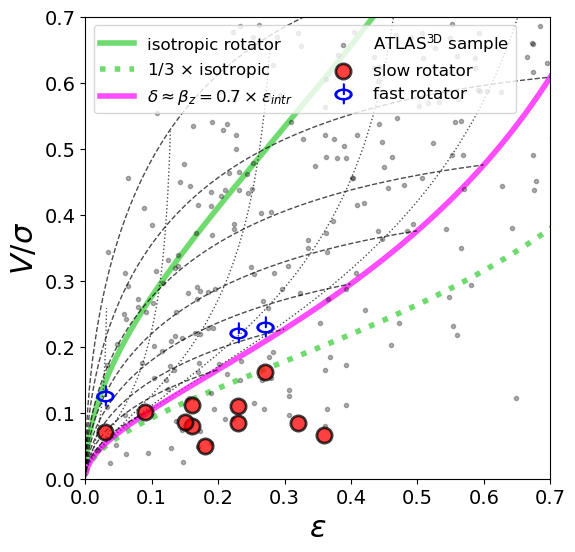

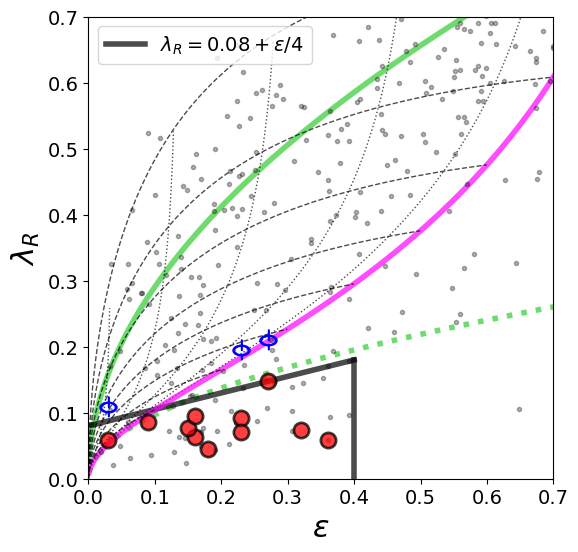

In [19]:
# plot the V_sigma and lambda_R to ellipticities


plt.figure(figsize=(6,6))
plt.xlim(0.0,0.7)#1.0)
plt.ylim(0.0,0.7)#1.0)

# curves
plt.plot(epsilons, V_sigmas_iso, 
         c='limegreen',linewidth=4,zorder=-1, alpha=0.7,
        label='isotropic rotator')
plt.plot(epsilons, 1/3 * V_sigmas_iso, 
         c='limegreen',linewidth=4,zorder=-1, alpha=0.7, linestyle=':',
        label=r'1/3 $\times$ isotropic')
# plot magenta and different inclinations
for i in range(len(incs)):
    if i == len(incs)-1:
        c='magenta'
        linestyle='-'
        label=r'$\delta\approx\beta_z=0.7\times\epsilon_{intr}$'
        linewidth=4
    else:
        c = 'k'
        linestyle=':'
        label=None
        linewidth=1
    plt.plot(epsilons, V_sigmas_magenta[i],
            c=c,linewidth=linewidth,zorder=-1, alpha=0.7,
             linestyle=linestyle,
            label=label)
# plot different epsilon intrinsic for magenta line
# plot magenta and different eps_intr
for i in range(len(eps_intrs)):
    c = 'k'
    linestyle='--'
    label=None
    linewidth=1
    plt.plot(epsilons, V_sigmas_mag_intrs[i],
            c=c,linewidth=linewidth,zorder=-1, alpha=0.7,
             linestyle=linestyle,
            label=label)
    
########
# atlas3d points
plt.scatter(a3d_eps_vs_lr[:,0], a3d_eps_vs_lr[:,1], c='k', marker='.', alpha=0.3, zorder=-1, label=r'$\rm{ATLAS^{3D}}$ sample')

# scatter plot for the datapoints
plt.scatter(eps_slow, V_sigmas_pix_slow[:], 
            s=120, c='r', marker=nonregular, edgecolor='k', linewidth=2,
            label='slow rotator', alpha=0.75)
plt.scatter(eps_fast, V_sigmas_pix_fast[:], 
            s=230, c='b', marker=rotator, 
            label='fast rotator')#detectable rotation')
#plt.scatter(eps_uncertain, V_sigmas_pix_uncertain[:], 
#            s=150, c='k', marker=uncertain_mark, linewidth=0.5, 
#            label='uncertain')
#plt.scatter(eps_fast_kdc, V_sigmas_pix_fast_kdc[:], 
#            s=150, marker='^', edgecolor='red', facecolor='none', linewidth=2, 
#            label='KDC')

plt.xlabel(r'$\epsilon$',fontsize=22)
plt.ylabel(r'$V/\sigma$',fontsize=22)
plt.legend(fontsize=12, loc='upper left', ncol=2)
#if j != 3:
#    plt.title(f'S/N {vorbin_SN_targets[j]}')
#plt.savefig(f'{kinematics_dir}/kinematic_classes_vsigma_02192024.png')
#plt.savefig(f'{kinematics_dir}/kinematic_classes_vsigma_02192024.pdf')

###################################
# Lambda_R

plt.figure(figsize=(6,6))
plt.xlim(0.0,0.7)#1.0)
plt.ylim(0.0,0.7)#1.0)

# curves
plt.plot(epsilons, lambda_Rs_iso, 
         c='limegreen',linewidth=4,zorder=-1, alpha=0.7)
plt.plot(epsilons, 1/3 * lambda_Rs_iso, 
         c='limegreen', linestyle=':', linewidth=4,zorder=-1, alpha=0.7)
plt.plot([0.0, 0.4],[0.08, 0.08+0.4/4],
         linestyle='-',c='k',linewidth=4,zorder=-1, alpha=0.7)
plt.plot([0.4, 0.4],[0.0, 0.08+0.4/4],
         linestyle='-',c='k',linewidth=4,zorder=-1, alpha=0.7,
        label=r'$\lambda_R = 0.08 + \epsilon/4$')
#plt.plot(epsilons, 0.31 * np.sqrt(epsilons), c='r')

# plot magenta and different inclinations
for i in range(len(incs)):
    if i == len(incs)-1:
        c='magenta'
        linestyle='-'
        #label=r'$\delta=0.7\times\epsilon_{intr}$'
        linewidth=4
    else:
        c = 'k'
        linestyle=':'
        label=None
        linewidth=1
    plt.plot(epsilons, V_sigmas_magenta[i],
            c=c,linewidth=linewidth,zorder=-1, alpha=0.7,
             linestyle=linestyle,
            label=label)
# plot different epsilon intrinsic for magenta line
# plot magenta and different eps_intr
for i in range(len(eps_intrs)):
    c = 'k'
    linestyle='--'
    label=None
    linewidth=1
    plt.plot(epsilons, V_sigmas_mag_intrs[i],
            c=c,linewidth=linewidth,zorder=-1, alpha=0.7,
             linestyle=linestyle,
            label=label)

# scatter plots for the datapoints
plt.scatter(eps_slow, lambda_Rs_pix_slow[:], 
            s=120, c='r', marker=nonregular, edgecolor='k', linewidth=2,
            #label='no rotation', 
            alpha=0.75)
plt.scatter(eps_fast, lambda_Rs_pix_fast[:], 
            s=230, c='b', marker=rotator, 
            #label='detectable rotation'
           )
#plt.scatter(eps_uncertain, lambda_Rs_pix_uncertain[:], 
#            s=150, c='k', marker=uncertain_mark, linewidth=0.5, 
            #label='uncertain'
#           )
plt.scatter(eps_fast_kdc, lambda_Rs_pix_fast_kdc[:], 
            s=150, marker='^', edgecolor='red', facecolor='none', linewidth=2, 
            #label='KDC'
           )

########
# atlas3d points
plt.scatter(a3d_eps_vs_lr[:,0], a3d_eps_vs_lr[:,2], c='k', marker='.', alpha=0.3, zorder=-1)

plt.xlabel(r'$\epsilon$',fontsize=22)
plt.ylabel(r'$\lambda_R$',fontsize=22)
plt.legend(fontsize=14, loc='upper left')
#if j != 3:
#    plt.title(f'S/N {vorbin_SN_targets}')
#plt.savefig(f'{kinematics_dir}/kinematic_classes_lambdar_02192024.png')
#plt.savefig(f'{kinematics_dir}/kinematic_classes_lambdar_02192024.pdf')

# Look at aperture effects by integrating velocities at a range of aperture radii.
# 1/4 reff, 1/2 reff, 3/4 reff, 1 reff, 1.25, 1.5 etc


In [29]:
# plug in the extra steps of doing the integral over luminosity weighted pixels instead of just the bins. Will be more spatially accurate as an aperture of radius reff

reff_factors = np.arange(0.1, 1.6, 0.1)

V_sigmas_aptest = np.zeros( (len(obj_names), len(reff_factors)) )
lambda_Rs_aptest = np.zeros_like( V_sigmas_aptest )
V_ap_int_aptest = np.zeros_like( V_sigmas_aptest )
VD_ap_int_aptest = np.zeros_like( V_sigmas_aptest )
dV_ap_int_aptest = np.zeros_like( V_sigmas_aptest )
dVD_ap_int_aptest = np.zeros_like( V_sigmas_aptest )


for i, obj_name in enumerate(obj_names):
    
    obj_name = obj_names[i]
    obj_abbr = obj_name[4:9]
    
    print('################################################################################################################')
    print('################################################################################################################')
    print('################################################################################################################')
    print('################################################################################################################')
    print('################################################################################################################')
    print()
    print(obj_name)
    print()
    print('################################################################################################################')
    print('################################################################################################################')
    print('################################################################################################################')
    print('################################################################################################################')
    print('################################################################################################################')
    
    kin_dir = f'{kinematics_dir}{obj_name}/'
    
    # get the kinematics from the january date
    with open(f'{kin_dir}{obj_name}_kinematics_{sps_name}_{date_of_kin}.pkl', 'rb') as file:
        kin_data = pickle.load(file)
        
    # get details from jampy for the velocity corrected by barycenter velocity
    with open(f'{kin_dir}{obj_name}_details_for_jampy_{sps_name}_{date_of_kin}.pkl', 'rb') as file:
        jam_data = pickle.load(file)

    #KCWI mosaic datacube
    mos_dir = f'{mosaics_dir}{obj_name}/'
    mos_name = f'KCWI_{obj_abbr}_icubes_mosaic_0.1457'

    target_dir = f'{kin_dir}target_sn_{vorbin_SN_target}/'
    # create kin_dir if not exists
    #Path(f'{target_dir}').mkdir(parents=True, exist_ok=True)

    '''
    Step 0: input the necessary information of the datacube
    '''
    
    #################
    # get velocity and bin data 

    # bin velocity dispersion
    _, VD_bin, _, dVD_bin, chi2_bin = kin_data.bin_kinematics.T
        
    # bin mean velocity
    V_bin = jam_data.V_bin
    dV_bin = jam_data.dV_bin
    
    # import voronoi binning data (#bins, 5215), spectrum for each bin
    voronoi_binning_data = kin_data.voronoi_binning_data 
    num_bins = len(voronoi_binning_data)
    # import pixel data for bins
    vorbin_pixels = kin_data.voronoi_binning_output
    
    # mask the bins greater than 350
    mask_bins = VD_bin > 350
    if any(mask_bins):
        VD_bin[mask_bins] = np.nan
        dVD_bin[mask_bins] = np.nan
        V_bin = np.insert(V_bin, np.argwhere(mask_bins)[0], np.nan)
        dV_bin = np.insert(dV_bin, np.argwhere(mask_bins)[0], np.nan)

    #################
    # get the right wavelength range from observations
    z = paper_table.loc[i, 'zlens']
    lo_ind, hi_ind = cut_wavelength_range (obj_abbr, mos_dir, z)
    print('Wavelength bounds for summation: ', lo_ind, hi_ind)        

    ######################################################################################
    ###########################################
    '''
    Now pixel method
    '''
    ###########################################
    ######################################################################################
    print()
    print('Starting pixel method...')
    print()
    print('################################################')

    # bring in cropped datacube and sum across wavelengths
    file = f'{mos_dir}{mos_name}_crop.fits'
    datacube = fits.getdata(file)
    summed_datacube = np.nansum(datacube[lo_ind:hi_ind], axis=0) # cut to the correct wavelength range
    normalized_summed_datacube = summed_datacube/np.sum(summed_datacube)

    # get effective radius
    effective_radius = paper_table.loc[i, 'reff_slacs']
    
    # calculate pixel luminosities
    pixel_luminosities = np.zeros(len(vorbin_pixels))
    for j in range(len(vorbin_pixels)):
        x = int(vorbin_pixels[j,0])
        y = int(vorbin_pixels[j,1])
        pixel_luminosity = summed_datacube[y,x]
        if pixel_luminosity < 0:
            print('negative pixel luminosity! ', pixel_luminosity)
            print('mean pixel luminosity, ', np.mean(pixel_luminosities))
            print('making this pixel 0 luminosity...')
            pixel_luminosity = 0
        pixel_luminosities[j] = pixel_luminosity

    #################
    # get mean R for each bin by pixel positions
    short_name = obj_name[4:]
    R = calc_R (vorbin_pixels, len(V_bin))
    print(f'length before cutting... {len(R)}')
    for m, factor in enumerate(reff_factors):
        print('factor ', factor)
        aperture_radius = factor*effective_radius
        condition = R < aperture_radius
        R_in_aperture = R[condition]
        V_in_aperture = V_bin[condition]
        VD_in_aperture = VD_bin[condition]
        dV_in_aperture = dV_bin[condition]
        dVD_in_aperture = dVD_bin[condition]
        print(f'length after cutting... {len(R_in_aperture)}')
        #print()

        ######################################################################################
        ###########################################
        '''
        Now pixel method only (no bin method, they give the same result)
        '''
        ###########################################
        ######################################################################################
        print()
        print('Starting pixel method...')
        print()
        print('################################################')


        # calculate luminosity weights for each bin contribution to the integrated velocities within the effective radius
        #shells=[1.]
        #luminosity_weights = calc_luminosity_weights_in_shells(vorbin_pixels, 
        #                                                       num_bins, 
        #                                                       bin_luminosities=None, 
        #                                                       pixel_luminosities, 
        #                                                       shells, 
        #                                                       aperture_radius)

        # calculate the luminosity-weighted mean V and VD for the aperture within the effective radius
        #sum_lum_weights = np.sum(luminosity_weights, axis=0) # sum over the weights for the normalization
        #normalized_lum_weights = luminosity_weights / sum_lum_weights

        # calculate V_sigma# calculate lambda_R
        V_sigmas_aptest[i,m], lambda_Rs_aptest[i,m], \
            V_ap_int_aptest[i,m], VD_ap_int_aptest[i,m], \
            dV_ap_int_aptest[i,m], dVD_ap_int_aptest[i,m]  = calc_aperture_velocities_from_lum_weight_pixels(vorbin_pixels, 
                                                                                                                             V_bin, VD_bin, dV_bin, dVD_bin, 
                                                                                                                             pixel_luminosities, 
                                                                                                                             aperture_radius)





################################################################################################################
################################################################################################################
################################################################################################################
################################################################################################################
################################################################################################################

SDSSJ0029-0055

################################################################################################################
################################################################################################################
################################################################################################################
###############################################################################

/tmp/ipykernel_114913/896716072.py:146: RuntimeWarning: invalid value encountered in scalar divide
  lambda_R = numerator / denominator


Wavelength bounds for summation:  1719 3936

Starting pixel method...

################################################
length before cutting... 85
factor  0.1
length after cutting... 5

Starting pixel method...

################################################
Masking NaN pixels.
lambda_R,  0.027922458409221335
factor  0.2
length after cutting... 16

Starting pixel method...

################################################
Masking NaN pixels.
lambda_R,  0.023982930965174797
factor  0.30000000000000004
length after cutting... 26

Starting pixel method...

################################################
Masking NaN pixels.
lambda_R,  0.03819322230425748
factor  0.4
length after cutting... 42

Starting pixel method...

################################################
Masking NaN pixels.
lambda_R,  0.05338424357954399
factor  0.5
length after cutting... 46

Starting pixel method...

################################################
Masking NaN pixels.
lambda_R,  0.05912028648583509
facto

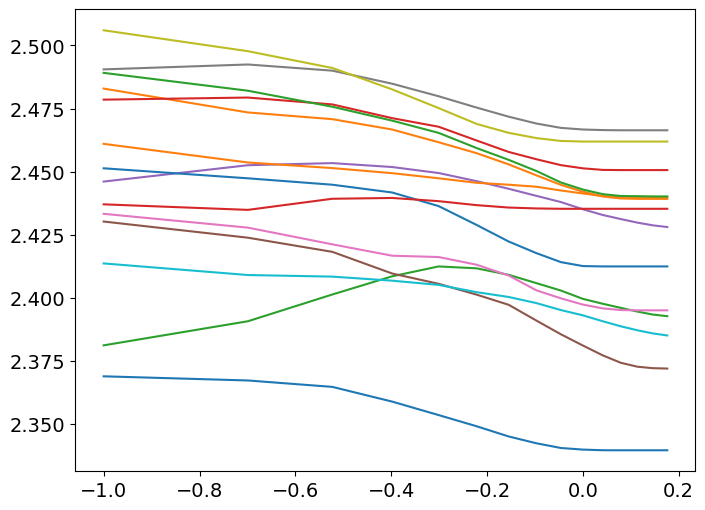

In [31]:
for i in range(len(obj_names)):
    plt.plot(np.log10(reff_factors), np.log10(VD_ap_int_aptest[i]))

In [38]:
# also show the 1/2 Reff measurement
VD_half_reff = VD_ap_int_aptest[:,4]
dVD_half_reff = dVD_ap_int_aptest[:,4]
VD_half_reff

array([225.68243909, 289.49538815, 258.47557951, 293.61958435,
       281.47536153, 254.40667434, 260.69891992, 301.9001231 ,
       298.65960699, 254.15245899, 273.10634167, 280.12468598,
       291.97673373, 274.33790698])

# Now integrated within 1.5 arcseconds.

In [42]:
# plug in the extra steps of doing the integral over luminosity weighted pixels instead of just the bins. Will be more spatially accurate as an aperture of radius reff

aperture_radius = 1.5

V_sigmas_sdssap = np.zeros( (len(obj_names)) ) #, len(reff_factors)) )
lambda_Rs_sdssap = np.zeros_like( V_sigmas_sdssap )
V_ap_int_sdssap = np.zeros_like( V_sigmas_sdssap )
VD_ap_int_sdssap = np.zeros_like( V_sigmas_sdssap )
dV_ap_int_sdssap = np.zeros_like( V_sigmas_sdssap )
dVD_ap_int_sdssap = np.zeros_like( V_sigmas_sdssap )


for i in range(14):
    
    obj_name = obj_names[i]
    obj_abbr = obj_name[4:9]
    
    print('################################################################################################################')
    print('################################################################################################################')
    print('################################################################################################################')
    print('################################################################################################################')
    print('################################################################################################################')
    print()
    print(obj_name)
    print()
    print('################################################################################################################')
    print('################################################################################################################')
    print('################################################################################################################')
    print('################################################################################################################')
    print('################################################################################################################')
    
    kin_dir = f'{kinematics_dir}{obj_name}/'
    
    # get the kinematics from the january date
    with open(f'{kin_dir}{obj_name}_kinematics_{sps_name}_{date_of_kin}.pkl', 'rb') as file:
        kin_data = pickle.load(file)
        
    # get details from jampy for the velocity corrected by barycenter velocity
    with open(f'{kin_dir}{obj_name}_details_for_jampy_{sps_name}_{date_of_kin}.pkl', 'rb') as file:
        jam_data = pickle.load(file)

    #KCWI mosaic datacube
    mos_dir = f'{mosaics_dir}{obj_name}/'
    mos_name = f'KCWI_{obj_abbr}_icubes_mosaic_0.1457'

    target_dir = f'{kin_dir}target_sn_{vorbin_SN_target}/'
    # create kin_dir if not exists
    #Path(f'{target_dir}').mkdir(parents=True, exist_ok=True)

    '''
    Step 0: input the necessary information of the datacube
    '''
    
    #################
    # get velocity and bin data 

    # bin velocity dispersion
    _, VD_bin, _, dVD_bin, chi2_bin = kin_data.bin_kinematics.T
        
    # bin mean velocity
    V_bin = jam_data.V_bin
    dV_bin = jam_data.dV_bin
    
    # import voronoi binning data (#bins, 5215), spectrum for each bin
    voronoi_binning_data = kin_data.voronoi_binning_data 
    num_bins = len(voronoi_binning_data)
    # import pixel data for bins
    vorbin_pixels = kin_data.voronoi_binning_output
    
    # mask the bins greater than 350
    mask_bins = VD_bin > 350
    if any(mask_bins):
        VD_bin[mask_bins] = np.nan
        dVD_bin[mask_bins] = np.nan
        V_bin = np.insert(V_bin, np.argwhere(mask_bins)[0], np.nan)
        dV_bin = np.insert(dV_bin, np.argwhere(mask_bins)[0], np.nan)

    #################
    # get the right wavelength range from observations
    z = paper_table.loc[i, 'zlens']
    lo_ind, hi_ind = cut_wavelength_range (obj_abbr, mos_dir, z)
    print('Wavelength bounds for summation: ', lo_ind, hi_ind)        

    ######################################################################################
    ###########################################
    '''
    Now pixel method
    '''
    ###########################################
    ######################################################################################
    print()
    print('Starting pixel method...')
    print()
    print('################################################')

    # bring in cropped datacube and sum across wavelengths
    file = f'{mos_dir}{mos_name}_crop.fits'
    datacube = fits.getdata(file)
    summed_datacube = np.nansum(datacube[lo_ind:hi_ind], axis=0) # cut to the correct wavelength range
    normalized_summed_datacube = summed_datacube/np.sum(summed_datacube)

    # get effective radius
    effective_radius = paper_table.loc[i, 'reff_slacs']

    # calculate pixel luminosities
    pixel_luminosities = np.zeros(len(vorbin_pixels))
    for j in range(len(vorbin_pixels)):
        x = int(vorbin_pixels[j,0])
        y = int(vorbin_pixels[j,1])
        pixel_luminosity = summed_datacube[y,x]
        if pixel_luminosity < 0:
            print('negative pixel luminosity! ', pixel_luminosity)
            print('mean pixel luminosity, ', np.mean(pixel_luminosities))
            print('making this pixel 0 luminosity...')
            pixel_luminosity = 0
        pixel_luminosities[j] = pixel_luminosity

    # calculate V_sigma# calculate lambda_R
    V_sigmas_sdssap[i], lambda_Rs_sdssap[i], \
        V_ap_int_sdssap[i], VD_ap_int_sdssap[i], \
        dV_ap_int_sdssap[i], dVD_ap_int_sdssap[i]  = calc_aperture_velocities_from_lum_weight_pixels(vorbin_pixels, 
                                                                                                                         V_bin, VD_bin, dV_bin, dVD_bin, 
                                                                                                                         pixel_luminosities, 
                                                                                                                         aperture_radius)
        




################################################################################################################
################################################################################################################
################################################################################################################
################################################################################################################
################################################################################################################

SDSSJ0029-0055

################################################################################################################
################################################################################################################
################################################################################################################
###############################################################################

# Bring in SLACS X data from table

In [32]:
slacs_x_data = np.genfromtxt(f'/data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/tables/slacs_x_data.txt', delimiter='')
slacs_x_names = np.genfromtxt(f'/data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/tables/slacs_x_data_names.txt', delimiter='', dtype='U15')
# make a dataframe
slacs_x = pd.DataFrame(slacs_x_data,
                      columns=['obj_name',
                              'reff_kpc',
                              'VD_half_reff',
                              'dVD_half_reff',
                              'log_stellar_mass_chab',
                              'dlog_stellar_mass_chab',
                              'log_stellar_mass_salp',
                              'dlog_stellar_mass_salp',
                              'log_M_half_reff',
                              'dlog_M_half_reff',
                              'fdm_chab',
                              'dfdm_chab',
                               'fdm_salp',
                               'dfdm_salp',
                               'gamma',
                               'dgamma'
                              ])
slacs_x['obj_name']=slacs_x_names

slacs_x['log_VD_half_reff'] = np.log10(slacs_x['VD_half_reff'])
slacs_x['dlog_VD_half_reff'] = 1/np.log(10) * slacs_x['dVD_half_reff']/slacs_x['VD_half_reff']



# Bring in updated velocity dispersions from Adam Bolton

In [35]:
# 02/23/23 - Updated SLACS SDSS velocity dispersions
# asb is the label, unsure of meaning
hdul = fits.open(f'{table_dir}vdisp_slacs_asb.fits')
hdul.verify('fix')
data = hdul[1].data
header = hdul[1].header

# take the VD, dVD and SDSS names

VD_slacs_asb_data = data['VDISP_ASB']
dVD_slacs_asb_data = data['VDISP_ASB_ERR']
slacs_obj_names_data = data['SDSS_NAME']

VD_slacs_asb = np.ones_like(VD_ap_int_rms)
dVD_slacs_asb = np.ones_like(VD_ap_int_rms)

for i, obj_name in enumerate(obj_names):
    obj_index = np.argwhere(slacs_obj_names_data == obj_name)[0][0]
    VD = VD_slacs_asb_data[obj_index]
    dVD = dVD_slacs_asb_data[obj_index]
    
    VD_slacs_asb[i] = VD
    dVD_slacs_asb[i] = dVD
    


# See how integrate VDs compare

In [48]:
VD_reff = VD_ap_int_rms
VD_sdssap = VD_ap_int_sdssap
dVD_reff = dVD_ap_int_rms
dVD_sdssap = dVD_ap_int_sdssap


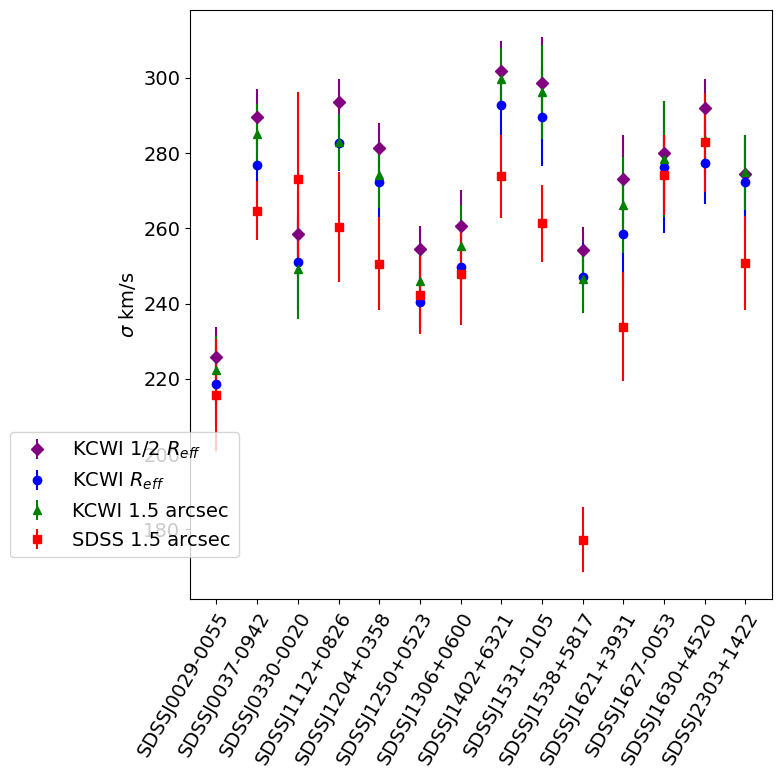

In [51]:
plt.rcParams.update({'font.size': 14})


plt.figure(figsize=(8,8))
x = range(14)
plt.errorbar(x, VD_half_reff[:], yerr=dVD_half_reff[:], c='purple', marker='D', linestyle='')
plt.errorbar(x, VD_reff[:], yerr=dVD_reff[:], c='b', marker='o', linestyle='')
plt.errorbar(x, VD_sdssap[:], yerr=dVD_sdssap[:], c='g', marker='^', linestyle='')
plt.errorbar(x, VD_slacs_asb, yerr=dVD_slacs_asb, c='r', marker='s', linestyle='')
plt.legend([r'KCWI 1/2 $R_{eff}$', 'KCWI $R_{eff}$', r'KCWI 1.5 arcsec', 'SDSS 1.5 arcsec'], 
                   bbox_to_anchor=(0.1,0.3))
plt.xticks(range(14), labels=obj_names, rotation=60, ha='right', rotation_mode='anchor')
plt.ylabel(r'$\sigma$ km/s')
plt.tight_layout()
#plt.savefig(f'{data_dir}aperture_integrated_velocity_dispersions_{date}.pdf', bbox_inches='tight')

In [53]:
reffs = paper_table['reff_slacs']

# Ratios and stuff

In [64]:
# import curve fit and define the power law to be fit
from scipy.optimize import curve_fit
#import uncertainties.unumpy as unp
#import uncertainties as unc

In [59]:
VD_ratios = np.ones_like( VD_ap_int_aptest )
dVD_ratios = np.ones_like(VD_ratios)

for i in range(14):
    # take the ratio of each velocity dispersion to the one at the effective radius
    for k in range(15):
        VD_ratio = VD_ap_int_aptest[i,k] / VD_ap_int_aptest[i,9] # ratio wrt where reff_factors = 1
        VD_ratios[i,k] = VD_ratio
        dVD_ratio = VD_ratio * np.sqrt((dVD_ap_int_aptest[i,k]/VD_ap_int_aptest[i,k])**2 \
                                       + (dVD_ap_int_aptest[i,9]/VD_ap_int_aptest[i,9])**2)
        dVD_ratios[i,k] = dVD_ratio
        # take the effective radius factors as the x axis

pl weighted fit: mean -0.03275784082987066


NameError: name 'unc' is not defined

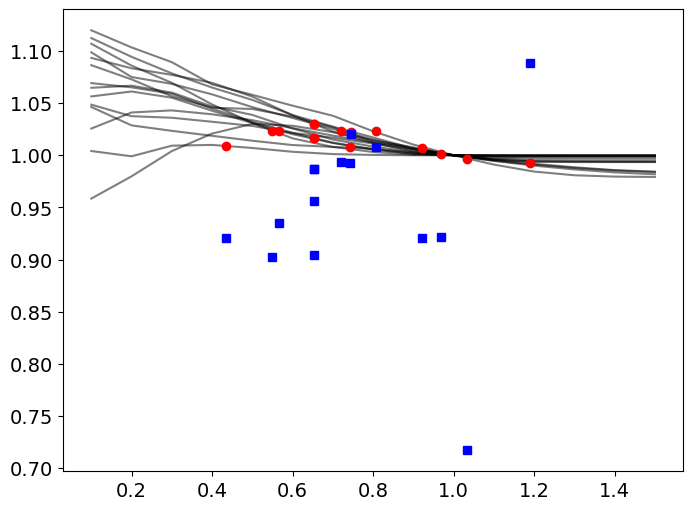

In [62]:
def power_law_fixed(x, a):
    return np.power(x, a)

# weighted
ps = np.zeros(14)
variances = np.zeros((14, 2))


aperture_ratios = 1.5/np.array(reffs)
sigma_ratios = VD_sdssap[:]/VD_reff[:]
sdss_ratios = VD_slacs_asb/VD_reff[:]
dsigma_ratios = sigma_ratios * np.sqrt((dVD_sdssap[:]/VD_sdssap[:])**2 + (dVD_reff[:]/VD_reff[:])**2)

fig, axs = plt.subplots(figsize=(8,6))#, gridspec_kw={'height_ratios': [4, 1]})
plt.subplots_adjust(hspace=0.25)
for i in range(14):
    # plot the data
    axs.plot(reff_factors, VD_ratios[i,:], c='k', alpha=0.5, zorder=-2)
    # weighted
    p, cov = curve_fit(f=power_law_fixed, xdata=reff_factors, ydata=VD_ratios[i,:], p0=[0], 
                       sigma=dVD_ratios[i,:], 
                       absolute_sigma=True,
                       bounds=(-np.inf, np.inf))
    ps[i] = p
    variances[i] = cov
    fit = power_law_fixed(reff_factors, p)
    #axs.plot(reff_factors, fit, c='r', linestyle=':', alpha=0.1)
    # plot the ratios of kcwi - 1.5 to reff
    if i==0:
        axs.scatter(aperture_ratios[i], sigma_ratios[i],#, yerr=dsigma_ratios[i],
                        marker='o', c='r', label=r'$\sigma_{KCWI,1.5}/\sigma_{eff}$')
        axs.plot(aperture_ratios[i], sdss_ratios[i], marker='s', c='b', label=r'$\sigma_{SDSS}/\sigma_{eff}$')
    axs.scatter(aperture_ratios[i], sigma_ratios[i],#, yerr=dsigma_ratios[i],
                marker='o', c='r')#, s=60)
    axs.plot(aperture_ratios[i], sdss_ratios[i], marker='s', c='b')

# take the weighted mean of parameters for each fit # (weighted by inverse variance)
# weighted
mean = np.average(ps)#, weights=1/variances_w[:,0])
mean_var = np.average(variances)
mean_err = np.sqrt(mean_var/14)

print('pl weighted fit: mean', mean)

# plot the fit curve relation
x=np.linspace(0.1, 1.5, 100)
ac = unc.correlated_values(np.array([mean]), np.array([[mean_var]])) # This accounts for the covariance terms so that it gives the proper std at each x for the confidence band
# calculate regression confidence interval
y = power_law_fixed(x, ac)
nom = unp.nominal_values(y) # the value of the fit
std = unp.std_devs(y)#/np.sqrt(len(log_stellar_masses[not_na])) # std at each x, makes the curve
# plot the regression
gamma = f'{"{:.3f}".format(mean)}\u00B1{"{:.3f}".format(mean_err)}'
#print(gamma)
label = f'y=$x^{{{gamma}}}$'
plt.plot(x, nom, c='r', label=label, linewidth=3, alpha=0.8, zorder=-1)
# uncertainty lines (95% confidence)
plt.fill_between(x, nom - std, nom + std,
                 color='r',
                 alpha=0.1#,\
         #label='95% Confidence Region'
                )

#mean_wfit = power_law_fixed(reff_factors, mean)
#mean_wfit_low = power_law_fixed(reff_factors, mean-mean_err)
#mean_wfit_hi = power_law_fixed(reff_factors, mean+mean_err)

#axs.plot(reff_factors, mean_wfit, c='b', linewidth=3, label=f'power law {"{:.3f}".format(mean)}$\pm${"{:.3f}".format(np.sqrt(mean_var))}')
#axs.fill_between(reff_factors, mean_wfit_low, mean_wfit_hi, color='b', alpha=0.2)
#axs[0].plot(reff_factors, mean_mean_fit_low, linewidth=10)
#axs[1].axhline(mean_var0, 0, 1, c='b')         

axs.legend()
axs.set_xlim(0.1, 1.5)
axs.set_xlabel(r'$R_{ap}/R_{eff}$')
axs.set_ylabel(r'$\sigma_{ap}/\sigma_{eff}$')
#axs[1].set_xlim(0.1, 1.5)
axs.set_ylim(0.975, 1.25)
#axs[1].set_yticks(np.arange(0.0, 0.15, 0.05))

#plt.savefig(f'{kinematics_dir}aperture_correction_power_law_SN{vorbin_SN_targets[j]}.png', bbox_inches='tight')
#plt.savefig(f'{kinematics_dir}aperture_correction_power_law_SN{vorbin_SN_targets[j]}.pdf', bbox_inches='tight')

# I really couldn't care any less about this. ^^^ Move on.

# Plot the aperture-integrated velocity dispersions with ratio of 1.5 arcsec apertures (KCWI vs SDSS)

In [67]:
SDSS_ap_ratios = np.ones_like(VD_sdssap)
dSDSS_ap_ratios = np.ones_like(VD_sdssap)

for j in range(4):
    SDSS_ap_ratios[:] = VD_sdssap[:]/VD_slacs_asb
    dSDSS_ap_ratios[:] = SDSS_ap_ratios[:]*np.sqrt((dVD_sdssap[:]/VD_sdssap[:])**2+(dVD_slacs_asb/VD_slacs_asb)**2)

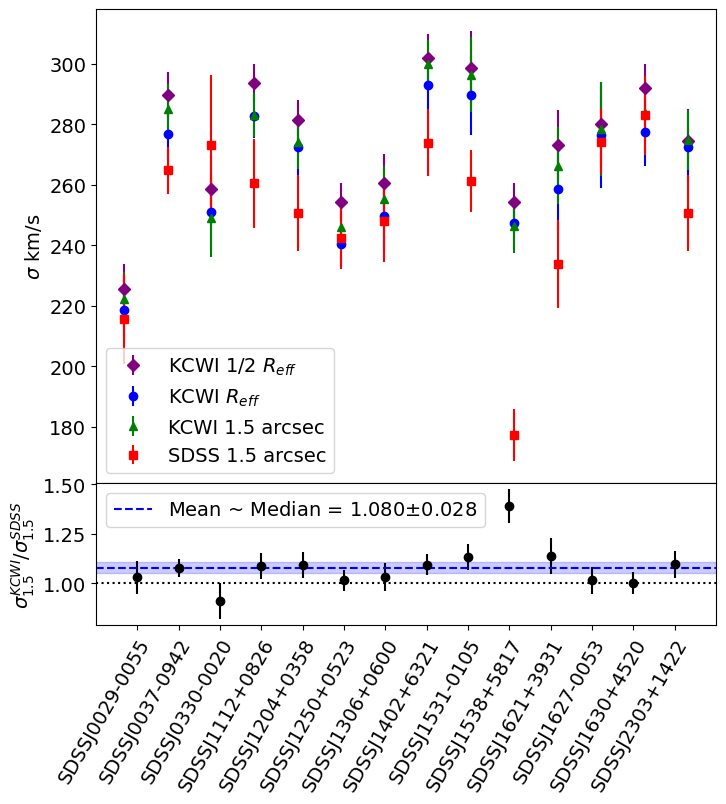

In [76]:
plt.rcParams.update({'font.size': 14})

mean = np.mean(SDSS_ap_ratios, axis=0)
err = np.std(SDSS_ap_ratios, axis=0)/np.sqrt(14)

fig, ax = plt.subplots(2,1,figsize=(8,8), gridspec_kw={'height_ratios': [10, 3]})
plt.subplots_adjust(hspace=0.0)

x = range(14)
ax[0].errorbar(x, VD_half_reff[:], yerr=dVD_half_reff[:], c='purple', marker='D', linestyle='')
ax[0].errorbar(x, VD_reff[:], yerr=dVD_reff[:], c='b', marker='o', linestyle='')
ax[0].errorbar(x, VD_sdssap[:], yerr=dVD_sdssap[:], c='g', marker='^', linestyle='')
ax[0].errorbar(x, VD_slacs_asb, yerr=dVD_slacs_asb, c='r', marker='s', linestyle='')
ax[0].legend([r'KCWI 1/2 $R_{eff}$', 'KCWI $R_{eff}$', r'KCWI 1.5 arcsec', 'SDSS 1.5 arcsec'], 
                   loc='lower left')#bbox_to_anchor=(0.1,0.3))
#ax[0].set_xticks(range(14), labels=obj_names, rotation=60, ha='right', rotation_mode='anchor')
ax[0].set_ylabel(r'$\sigma$ km/s')
if j != 3:
    ax[0].set_title(f'Bin S/N {vorbin_SN_targets[j]}')
#ax[0].tight_layout()

x = np.linspace(-1, 15, 100)
ylo = np.ones_like(x)*(mean-err)
yhi = np.ones_like(x)*(mean+err)

for i in range(len(VD_slacs_asb)):
    ax[1].errorbar(i, SDSS_ap_ratios[i], yerr=dSDSS_ap_ratios[i], color='k', marker='o')
ax[1].set_ylabel(r'${\sigma_{1.5''}^{KCWI}}/{\sigma_{1.5''}^{SDSS}}$')
ax[1].axhline(mean, 0, 1, color='b', linestyle='--', label=f'Mean ~ Median = {"{:.3f}".format(mean)}$\pm${"{:.3f}".format(err)}')
ax[1].fill_between(x, 
                ylo,
               yhi,
               color='b',
               alpha=0.2)
ax[1].axhline(1.0, 0, 1, color='k', linestyle=':')
ax[1].set_xlim(-1, 14)
ax[1].set_xticks(range(14), labels=obj_names, rotation=60, ha='right', rotation_mode='anchor')
ax[1].legend(loc='upper left')
#ax[0].set_title(f'Bin S/N {vorbin_SN_targets[j]}')

plt.savefig(f'{kinematics_dir}aperture_integrated_velocity_dispersions.pdf', bbox_inches='tight')
plt.savefig(f'{kinematics_dir}aperture_integrated_velocity_dispersions.png', bbox_inches='tight')

(165.0, 315.0)

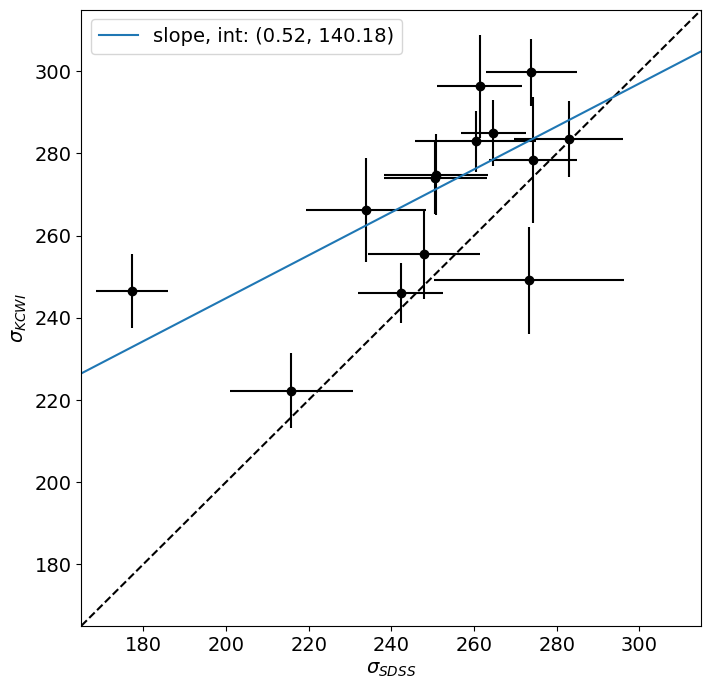

In [90]:
plt.figure(figsize=(8,8))
xx = np.linspace(165, 315, 100)
plt.errorbar(VD_slacs_asb, VD_sdssap, xerr=dVD_slacs_asb, yerr = dVD_sdssap, linestyle='None', c='k', marker='o')
plt.plot(xx, xx, '--', color='k')

# fit the line
p, cov = np.polyfit(VD_slacs_asb-250, VD_sdssap-250,
                    deg=1,
                    w=1/np.sqrt(dVD_slacs_asb**2+dVD_sdssap**2),
                    cov='unscaled')
m = p[0]
b = p[1]
err = np.sqrt(np.diag(cov))#/np.sqrt(len(log_stellar_masses))
merr = err[0]
berr = err[1]

plt.plot(xx, m*(xx-250)+b+250, label=f'slope, int: {np.around(m, 2), np.around(b+250*(1 - m), 2) }')
plt.legend()
plt.xlim(165, 315)
plt.xlabel(r'$\sigma_{SDSS}$')
plt.ylabel(r'$\sigma_{KCWI}$')
plt.ylim(165, 315)

In [91]:
b

20.90102161929784